###**Hybrid Classification Model Overview**

**What is this code?**

It's a neural network model that performs:

- Classification: Identifies the class of the input data (e.g., one of the five categories ['F', 'N', 'S', 'V', 'Q']). (Uses CNN + LSTM)


**What are the main parts of the model?**

- Encoder: Compresses the input data into a smaller, meaningful "latent space" representation.
- Classifier: Uses the same latent space to determine which class the input belongs to (one of F, N, S, V, Q).

###**Explanation of the Model Architecture**

**Encoder:**

Takes input data and extracts key features using layers like:

Convolutional layers: Identify patterns in the data.
LSTM (Long Short-Term Memory): Useful for sequential data (like time series or signals).

The result is a smaller "latent representation" that summarizes the input.


**Classifier:**

Takes the latent representation and predicts the class of the input signal (e.g., F, N, S, V, Q).


### **What Does the Model Do?**

**Input:**

A single signal (a heartbeat pattern of length 280).

**Processing:**

- The signal is compressed into a smaller representation (via the encoder).
- The latent space is used to Predict its class (classifier).

**Output:**

- Class prediction: One of the five classes (F, N, S, V, Q).







In [ ]:
import numpy as np
import scipy.io as spio
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Step 1: Pre-processing Function
def read_mitbih(filename, max_time=100, classes=['F', 'N', 'S', 'V', 'Q']):
    def normalize(data):
        data = np.nan_to_num(data)  # removing NaNs and Infs
        data = data - np.mean(data)
        data = data / np.std(data)
        return data

    # Read data
    data = []
    samples = spio.loadmat(filename + ".mat")
    samples = samples['s2s_mitbih']
    values = samples[0]['seg_values']
    labels = samples[0]['seg_labels']
    num_annots = sum([item.shape[0] for item in values])

    n_seqs = num_annots / max_time
    l_data = 0
    for i, item in enumerate(values):
        l = item.shape[0]
        for itm in item:
            if l_data == n_seqs * max_time:
                break
            data.append(itm[0])
            l_data += 1

    l_labels = 0
    t_labels = []
    for i, item in enumerate(labels):
        if len(t_labels) == n_seqs * max_time:
            break
        item = item[0]
        for label in item:
            if l_labels == n_seqs * max_time:
                break
            t_labels.append(str(label))
            l_labels += 1

    del values
    data = np.asarray(data)
    shape_v = data.shape
    data = np.reshape(data, [shape_v[0], -1])
    t_labels = np.array(t_labels)

    # Combine all samples for the specified classes
    _data = np.asarray([], dtype=np.float64).reshape(0, shape_v[1])
    _labels = np.asarray([], dtype=np.dtype('|S1')).reshape(0,)
    for cl in classes:
        _label = np.where(t_labels == cl)
        _data = np.concatenate((_data, data[_label[0]]))
        _labels = np.concatenate((_labels, t_labels[_label[0]]))

    data = _data[:(len(_data) // max_time) * max_time, :]
    _labels = _labels[:(len(_data) // max_time) * max_time]

    data = [data[i:i + max_time] for i in range(0, len(data), max_time)]
    labels = [_labels[i:i + max_time] for i in range(0, len(_labels), max_time)]
    permute = np.random.permutation(len(labels))
    data = np.asarray(data)
    labels = np.asarray(labels)
    data = data[permute]
    labels = labels[permute]

    print('Records processed!')
    return data, labels


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#optional: only checking the accessiblity
import os
print(os.path.exists("/content/drive/My Drive/s2s_mitbih_aami.mat"))

True


In [ ]:
# Step 2: Load and Process Data
#filename = "s2s_mitbih_aami"
filename = "/content/drive/My Drive/s2s_mitbih_aami"
max_time = 1
classes = ['F', 'N', 'S', 'V', 'Q']

# Load the data and labels
data, labels = read_mitbih(filename, max_time=max_time, classes=classes)
data = data.astype(np.float32)

# Encode the labels as integers (F=0, N=1, etc.)
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)  # Encode labels into integers

Records processed!


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.15, random_state=45, shuffle=True
)

In [ ]:
!pip install imbalanced-learn

In [ ]:
# TRIAL TUNING: Handling Imbalance Data with SMOTE
from imblearn.over_sampling import SMOTE

# SMOTE for oversampling in training data
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Ubah ke format 2D untuk SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Return the shape of training data into 3D
X_train_resampled = X_train_resampled.reshape(-1, X_train.shape[1], X_train.shape[2])

print("Shape after SMOTE:")
print("X_train_resampled:", X_train_resampled.shape)
print("y_train_resampled:", y_train_resampled.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Shape after SMOTE:
X_train_resampled: (384210, 1, 280)
y_train_resampled: (384210,)


In [ ]:
class HybridAutoEncoder(Model):
    def __init__(self, input_dim, latent_dim, num_classes=5):
        super(HybridAutoEncoder, self).__init__()

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(input_dim, 1)),
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.BatchNormalization(),
            layers.MaxPooling1D(2, padding="same"),
            layers.LSTM(latent_dim, activation='tanh', return_sequences=False)
        ])

        # Calculate reduced time dimension
        from math import ceil
        self.reduced_time_dim = ceil(input_dim / 4)

        # Decoder for reconstruction
        self.decoder = tf.keras.Sequential([
            layers.RepeatVector(self.reduced_time_dim),
            layers.LSTM(latent_dim, activation='tanh', return_sequences=True),
            layers.Conv1D(128, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(64, 3, strides=1, activation='relu', padding="same"),
            layers.UpSampling1D(2),
            layers.BatchNormalization(),
            layers.Conv1D(1, 3, strides=1, activation='sigmoid', padding="same")
        ])

        # Classification head
        self.classifier = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation='softmax')
        ])

        # Build the model by calling it with a dummy input
        # This forces variable creation during initialization
        dummy_input = tf.keras.Input(shape=(input_dim, 1))
        self(dummy_input)

    def call(self, X):
        # Encode input to latent space
        encoded = self.encoder(X)

        # Reconstruction from latent space
        decoded = self.decoder(encoded)

        # Classification from latent space
        classification_output = self.classifier(encoded)

        return {"reconstruction": decoded, "classification": classification_output}


In [ ]:
# Create the hybrid model
input_dim = 280  # Time steps of input data
latent_dim = 32  # Latent space dimension
num_classes = 5  # Number of classes
hybrid_autoencoder = HybridAutoEncoder(input_dim=input_dim, latent_dim=latent_dim, num_classes=num_classes)

# Compile the model
hybrid_autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss={
        "reconstruction": "mae",  # Loss for reconstruction
        "classification": "sparse_categorical_crossentropy"  # Loss for classification
    },
    metrics={
        "reconstruction": [],  # Optional metrics for reconstruction
        "classification": ["accuracy"]  # Accuracy metric for classification
    }
)


In [ ]:
# BEFORE RESHAPE
print("X_train:", X_train.shape)
print("X_train_resampled:", X_train_resampled.shape)
print("X_test:", X_test.shape)

X_train: (92937, 1, 280)
X_train_resampled: (384210, 1, 280)
X_test: (16401, 1, 280)


In [ ]:
# Ensure correct input shape
X_train_resampled = X_train_resampled.reshape(-1, 280, 1)  # (samples, time_steps, features)
X_train = X_train.reshape(-1, 280, 1)  # (samples, time_steps, features)
X_test = X_test.reshape(-1, 280, 1)

# AFTER RESHAPE
print("X_train:", X_train.shape)
print("X_train_resampled:", X_train_resampled.shape)
print("X_test:", X_test.shape)

X_train: (92937, 280, 1)
X_train_resampled: (384210, 280, 1)
X_test: (16401, 280, 1)


In [ ]:
# Training with Callbacks - testing ##D
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)


In [ ]:
#training
history = hybrid_autoencoder.fit(
    X_train_resampled,
    {"reconstruction": X_train_resampled, "classification": y_train_resampled},
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
10806/10806 ━━━━━━━━━━━━━━━━━━━━ 199s 17ms/step - classification_accuracy: 0.8309 - classification_loss: 0.4572 - loss: 1.0705 - reconstruction_loss: 0.6134 - val_classification_accuracy: 0.9348 - val_classification_loss: 0.2207 - val_loss: 1.0319 - val_reconstruction_loss: 0.8112 - learning_rate: 0.0010
Epoch 2/50
10806/10806 ━━━━━━━━━━━━━━━━━━━━ 194s 17ms/step - classification_accuracy: 0.9563 - classification_loss: 0.1257 - loss: 0.6634 - reconstruction_loss: 0.5377 - val_classification_accuracy: 0.9488 - val_classification_loss: 0.1445 - val_loss: 0.9367 - val_reconstruction_loss: 0.7922 - learning_rate: 0.0010
Epoch 3/50
10806/10806 ━━━━━━━━━━━━━━━━━━━━ 203s 17ms/step - classification_accuracy: 0.9693 - classification_loss: 0.0868 - loss: 0.6170 - reconstruction_loss: 0.5302 - val_classification_accuracy: 0.9641 - val_classification_loss: 0.1179 - val_loss: 0.9033 - val_reconstruction_loss: 0.7854 - learning_rate: 0.0010
Epoch 4/50
10806/10806 ━━━━━━━━━━━━━━━━━━━━ 177s 

In [ ]:
# # Train the model
# history = hybrid_autoencoder.fit(
#     X_train_resampled,  # Input data
#     {"reconstruction": X_train_resampled, "classification": y_train_resampled},  # Output data for both tasks
#     epochs=10,
#     batch_size=32,
#     validation_split=0.1,
#     verbose=1
# )


In [ ]:
model_save_path = "hybrid_autoencoder_model.h5"
hybrid_autoencoder.save(model_save_path)
print(f"Model saved in HDF5 format at {model_save_path}")


files.download(model_save_path)

model_save_path3 = "hybrid_autoencoder_model.keras"
hybrid_autoencoder.save(model_save_path3)
files.download(model_save_path3)


torch.save(HybridAutoEncoder,"hybrid_autoencoder_model.pth")

print("Model saved as hybrid_autoencoder_model.pth")

files.download("hybrid_autoencoder_model.pth")


Model saved in HDF5 format at hybrid_autoencoder_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Model saved as hybrid_autoencoder_model.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Evaluate on test data
results = hybrid_autoencoder.evaluate(
    X_test,
    {"reconstruction": X_test, "classification": y_test}
)

print(f"Reconstruction Loss: {results[1]}")  # Reconstruction loss
print(f"Classification Accuracy: {results[3]}")  # Classification accuracy


513/513 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - classification_accuracy: 0.9845 - classification_loss: 0.0829 - loss: 0.5458 - reconstruction_loss: 0.4629
Reconstruction Loss: 0.08849824965000153
Classification Accuracy: 0.9852448105812073


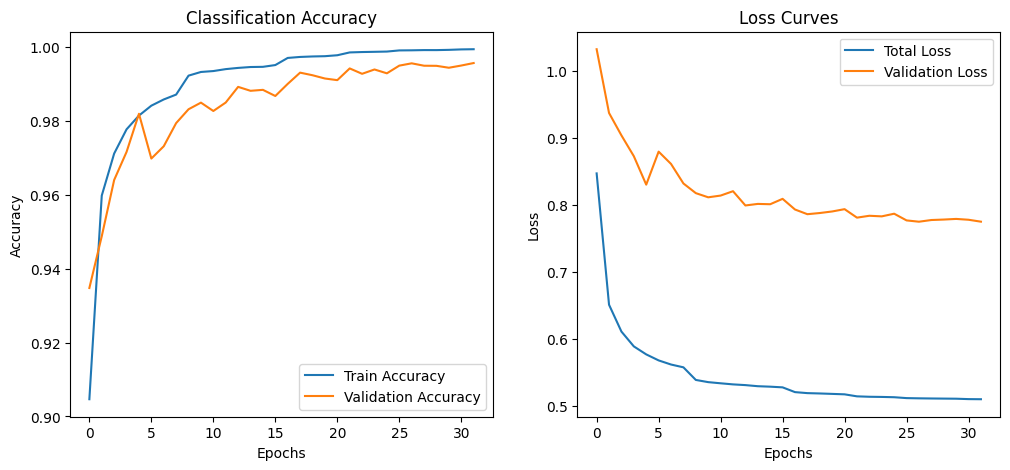

In [ ]:
##Ploting
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['classification_accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_classification_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Total Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()

plot_training_curves(history)

In [ ]:
# Example input data
new_input = np.random.rand(1, input_dim, 1).astype(np.float32)  # Replace with actual input

# Predict
predictions = hybrid_autoencoder.predict(new_input)

# Get reconstructed output
reconstructed_output = predictions["reconstruction"]

# Get predicted class
class_probs = predictions["classification"]
predicted_class = np.argmax(class_probs, axis=1)

print(f"Reconstructed Output Shape: {reconstructed_output.shape}")
print(f"Predicted Class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
Reconstructed Output Shape: (1, 280, 1)
Predicted Class: [1]


In [ ]:
# Predict classification outputs
predictions = hybrid_autoencoder.predict(X_test)
predicted_probs = predictions["classification"]  # Softmax probabilities
threshold = 0.6  # adjust threshold for majority class
predicted_classes = np.argmax(predicted_probs, axis=1)  # Get class indices

# Improve the prediction of majority class (N)
predicted_classes[predicted_probs[:, 0] > threshold] = 0

513/513 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step


In [ ]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_classes)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[  100    12     1     0     8]
 [   17 13512    13    78    40]
 [    0     5  1136     0     0]
 [    0    27     0   365     2]
 [    7    24     2     6  1046]]


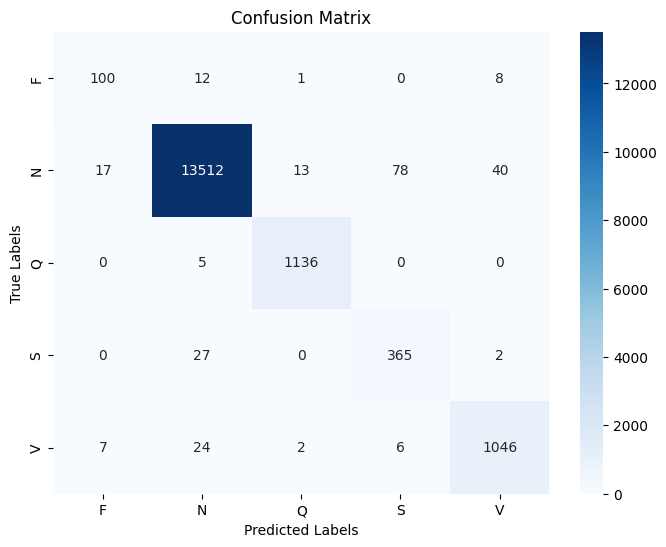

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the class labels (ensure they match the encoding)
class_labels = ['F', 'N', 'Q', 'S', 'V']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Compute accuracy
accuracy = accuracy_score(y_test, predicted_classes)

# Compute precision, recall, and F2-score
precision = precision_score(y_test, predicted_classes, average='weighted')
recall = recall_score(y_test, predicted_classes, average='weighted')
f2_score = fbeta_score(y_test, predicted_classes, beta=2, average='weighted')  # F2-score

# Print metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F2 Score: {f2_score:.2f}")


Accuracy: 0.99
Precision: 0.99
Recall: 0.99
F2 Score: 0.99


In [ ]:
from sklearn.metrics import classification_report

# Print classification metric report for each class
report = classification_report(y_test, predicted_classes, target_names=['F', 'N', 'Q', 'S', 'V'])
print(report)

              precision    recall  f1-score   support

           F       0.81      0.83      0.82       121
           N       0.99      0.99      0.99     13660
           Q       0.99      1.00      0.99      1141
           S       0.81      0.93      0.87       394
           V       0.95      0.96      0.96      1085

    accuracy                           0.99     16401
   macro avg       0.91      0.94      0.92     16401
weighted avg       0.99      0.99      0.99     16401

